# Transfer Learning With TensorFlow part 1: Feature Extraction

## Downloading and becoming one with the data

In [1]:
import zipfile


!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref  = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-10-31 13:00:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.207, 108.177.127.207, 172.217.218.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.2MB/s    in 4.5s    

2023-10-31 13:00:23 (35.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

for dp, dn, fn in os.walk('10_food_classes_10_percent'):
  print(len(dp),len(dn),len(fn))

26 2 0
31 10 0
37 0 250
37 0 250
41 0 250
45 0 250
37 0 250
42 0 250
37 0 250
46 0 250
41 0 250
45 0 250
32 10 0
38 0 75
38 0 75
42 0 75
46 0 75
38 0 75
43 0 75
38 0 75
47 0 75
42 0 75
46 0 75


## Creating data loaders (preparing the data)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size = BATCH_SIZE
)
test_data_10_percent = test_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size = BATCH_SIZE
)

Found 750 images belonging to 10 classes.
Found 750 images belonging to 10 classes.


## Setting Up Callbacks

In [4]:
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  print(f"Saving TensorBoard Log Files to: {log_dir}")
  return tensorboard_callback


## Creating Models Using TensorFlow Hub
> tfhub.dev

In [5]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
IMG_SHAPE+(3,)

(224, 224, 3)

In [8]:
def create_model(model_url,num_classes=10):
  """
  Takes a tensorflow hub url and creates a keras sequential model with it
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False,
                                          name= 'Feature_Extraction_layer',
                                          input_shape=IMG_SHAPE+(3,))


  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation='softmax',name='OUTPUT')
  ])

  return model

In [9]:
# Create REsent model
resent_model = create_model(resnet_url,
                            train_data_10_percent.num_classes)

In [10]:
# Compile resent model
resent_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [11]:
# Fit the model


resent_history = resent_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorboard_callback('Transfer_learning','RESENT_MODEL')])

Saving TensorBoard Log Files to: Transfer_learning/RESENT_MODEL/20231031-130036
Epoch 1/5
24/24 [==============================] - 18s 261ms/step - loss: 1.8649 - accuracy: 0.3840 - val_loss: 1.0330 - val_accuracy: 0.7000
Epoch 2/5
24/24 [==============================] - 5s 208ms/step - loss: 0.8672 - accuracy: 0.7373 - val_loss: 0.6638 - val_accuracy: 0.8013
Epoch 3/5
24/24 [==============================] - 8s 324ms/step - loss: 0.6028 - accuracy: 0.8293 - val_loss: 0.4765 - val_accuracy: 0.8827
Epoch 4/5
24/24 [==============================] - 5s 209ms/step - loss: 0.4640 - accuracy: 0.8840 - val_loss: 0.3771 - val_accuracy: 0.9187
Epoch 5/5
24/24 [==============================] - 5s 229ms/step - loss: 0.3643 - accuracy: 0.9187 - val_loss: 0.3066 - val_accuracy: 0.9387


In [12]:
resent_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 OUTPUT (Dense)              (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs,loss,label='training_loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.legend()
  plt.figure()
  plt.plot(epochs,accuracy,label='accuracy')
  plt.plot(epochs,val_accuracy,label='val_accuracy')
  plt.legend();

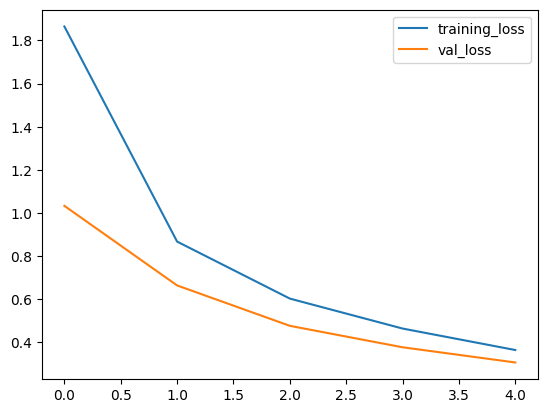

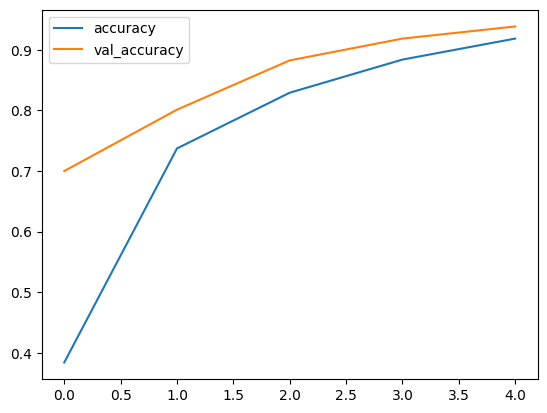

In [14]:
plot_loss_curves(resent_history)

In [15]:
# Create EffecientNet model
efficientnet_model = create_model(efficientnet_url,
                            train_data_10_percent.num_classes)

In [16]:
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [17]:
efficientnet_history = efficientnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data= test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback('Transfer_learning','Efficient_MODEL')]
)

Saving TensorBoard Log Files to: Transfer_learning/Efficient_MODEL/20231031-130143
Epoch 1/5
24/24 [==============================] - 16s 253ms/step - loss: 1.8564 - accuracy: 0.4333 - val_loss: 1.2919 - val_accuracy: 0.7533
Epoch 2/5
24/24 [==============================] - 5s 224ms/step - loss: 1.0596 - accuracy: 0.7907 - val_loss: 0.8316 - val_accuracy: 0.8480
Epoch 3/5
24/24 [==============================] - 5s 224ms/step - loss: 0.7484 - accuracy: 0.8573 - val_loss: 0.6381 - val_accuracy: 0.8800
Epoch 4/5
24/24 [==============================] - 5s 193ms/step - loss: 0.5968 - accuracy: 0.8853 - val_loss: 0.5270 - val_accuracy: 0.8987
Epoch 5/5
24/24 [==============================] - 5s 193ms/step - loss: 0.5055 - accuracy: 0.8960 - val_loss: 0.4525 - val_accuracy: 0.9147


In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 OUTPUT (Dense)              (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [19]:
!tensorboard dev upload --logdir ./Transfer_learning \
--name "efficientNetB0 vs ResNet50V2" \
--description "comparing two models on tensorflow x12" \
--one_shot

2023-10-31 13:02:26.555093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 13:02:26.555147: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 13:02:26.555185: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 13:02:27.832088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./Transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your us

In [20]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [25]:
resent_model.predict(tf.expand_dims(steak,axis=0))

1/1 [==============================] - 2s 2s/step


array([[0.07062303, 0.09368115, 0.10618094, 0.3816309 , 0.05428956,
        0.01120822, 0.0076708 , 0.05241988, 0.1892735 , 0.03302203]],
      dtype=float32)